In [1]:
import argparse, os, sys, glob
import torch
import cv2
import time
import datetime
import numpy as np
from PIL import Image
from vggloss import *
from torchvision.utils import save_image
import torchvision
from torch import autocast
from einops import rearrange
from tqdm import tqdm, trange
from omegaconf import OmegaConf
from imwatermark import WatermarkEncoder
from itertools import islice
from torchvision.utils import make_grid
from pytorch_lightning import seed_everything
from contextlib import contextmanager, nullcontext
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from transformers import AutoFeatureExtractor

# environment
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# helper
toTensor = torchvision.transforms.ToTensor()

# path
experiment_time_stamp = datetime.date.today()
config_path = "/home/v-penxiao/workspace/DailyExperiments/stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
# diffusion_model_path = "/home/v-penxiao/workspace/DailyCkpts/stable_diffusion/v1-5-pruned.ckpt"
diffusion_model_path = "/home/v-penxiao/workspace/DailyCkpts/stable_diffusion/sd-v1-4-full-ema.ckpt "
img_path = "/home/v-penxiao/workspace/DailyExperiments/stable-diffusion/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
output_path = os.path.join("/home/v-penxiao/workspace/DailyOutputs/stable_outputs/imagic_outputs", str(datetime.date.today()).replace("-","_"))
cond_path = os.path.join(output_path, "opti_cond_xloss.pt")
unet_path = os.path.join(output_path, "opti_unet_xloss.pt")
sample_path = os.path.join(output_path, "samples")
os.makedirs(output_path, exist_ok=True)
os.makedirs(sample_path, exist_ok=True)
base_count = len(os.listdir(sample_path))
grid_count = len(os.listdir(output_path)) - 1
torch.manual_seed(0)
wm = "StableDiffusionV1"
wm_encoder = WatermarkEncoder()
wm_encoder.set_watermark('bytes', wm.encode('utf-8'))

/anaconda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def gpu_info() -> str:
    info = ''
    for id in range(torch.cuda.device_count()):
        p = torch.cuda.get_device_properties(id)
        info += f'CUDA:{id} ({p.name}, {p.total_memory / (1 << 20):.0f}MiB)\n'
    return info[:-1]


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model


def put_watermark(img, wm_encoder=None):
    if wm_encoder is not None:
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = wm_encoder.encode(img, 'dwtDct')
        img = Image.fromarray(img[:, :, ::-1])
    return img


def load_replacement(x):
    try:
        hwc = x.shape
        y = Image.open("assets/rick.jpeg").convert("RGB").resize((hwc[1], hwc[0]))
        y = (np.array(y)/255.0).astype(x.dtype)
        assert y.shape == x.shape
        return y
    except Exception:
        return x


def check_safety(x_image):
    return x_image, False

def generate_by_prompt(wm_encoder, c, samplER, model, outpath, start_code, h=256, w=256, ddim_eta=0.0, n_samples=1, scale=7.5,
                       ddim_steps=50):
    
    sample_path = os.path.join(output_path, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(output_path)) - 1
    all_samples = list()

    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                uc = None
                if scale != 1.0:
                    uc = model.get_learned_conditioning(batch_size * [""])
#                 c = model.get_learned_conditioning([prompt])
                shape = [4, h // 8, w // 8]
                samples_ddim, _ = samplER.sample(S=ddim_steps,
                                                 conditioning=c,
                                                 batch_size=n_samples,
                                                 shape=shape,
                                                 verbose=False,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=uc,
                                                 eta=ddim_eta,
                                                 x_T=start_code)
                
                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
                x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

                x_checked_image, has_nsfw_concept = check_safety(x_samples_ddim)
                x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)

                if True:
                    for x_sample in x_checked_image_torch:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        img = Image.fromarray(x_sample.astype(np.uint8))
                        img = put_watermark(img, wm_encoder)
                        img.save(os.path.join(sample_path, f"{base_count:05}.png"))
                        base_count += 1

                if False:
                    all_samples.append(x_checked_image_torch)

                if False:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    img = Image.fromarray(grid.astype(np.uint8))
                    img = put_watermark(img, wm_encoder)
                    img.save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                return samples_ddim

def degration(image):
    # transform the image to gray-scale
    r = image[:, 0, :, :]
    g = image[:, 1, :, :]
    b = image[:, 2, :, :]
    n, _, h, w = image.size()
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    image = gray.view(n, 1, h, w).expand(n, 3, h, w)
    return image



In [3]:
gpu_info()

'CUDA:0 (NVIDIA A100 80GB PCIe, 80995MiB)'

In [4]:
config = OmegaConf.load(config_path)
model = load_model_from_config(config, diffusion_model_path)
model = model.to(device)
vgg = VGGPerceptualLoss().to(model.device)

if False:
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)
start_code = None

if False:
    start_codenamed_parametersrandn([n_samples, 4, H // 8, W // 8], device=device)
    
precision_scope = autocast if True else nullcontext
batch_size = 1
n_rows = batch_size

Loading model from /home/v-penxiao/workspace/DailyCkpts/stable_diffusion/sd-v1-4-full-ema.ckpt 


FileNotFoundError: [Errno 2] No such file or directory: '/home/v-penxiao/workspace/DailyCkpts/stable_diffusion/sd-v1-4-full-ema.ckpt '

In [ ]:
prompt = "a photograph of a yellow dog sitting on a black bench, background is blue sky and green grass land."
# prompt = "a colorful photograph of a black horse standing on a path in the countryside with a clear sky in the background."
src_image = np.array(Image.open(img_path).convert("RGB"))
src_image = src_image.astype(np.float32) / 255.0
src_image = src_image[None].transpose(0, 3, 1, 2)
src_image = torch.from_numpy(src_image)
src_image = src_image * 2.0 - 1.0
src_image = src_image.to(device)

un_cond = model.get_learned_conditioning(batch_size * [""])
cond = model.get_learned_conditioning([prompt])
src_image_latent = model.encode_first_stage(src_image)
x_start = model.get_first_stage_encoding(src_image_latent)

cond.requires_grad = True
cond_copy = cond.clone()
x_start.requires_grad = True

In [ ]:
with torch.no_grad():
    _ = generate_by_prompt(wm_encoder=wm_encoder, c=cond, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=batch_size, scale=3, ddim_steps=45)


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:03<00:00, 14.65it/s]


In [8]:
'''
    #1. embedding optimization
'''
print("-" * 20, "embedding optimization", "-" * 20)
optimizer = torch.optim.Adam([cond], lr=0.001)
criteria = torch.nn.MSELoss()
history = []
steps = 500
for t_int in range(steps):
    optimizer.zero_grad()
    
    noise = torch.randn_like(x_start)
    t_tensor = torch.randint(0, model.num_timesteps, (x_start.shape[0],), device=model.device).long()
    x_noisy = model.q_sample(x_start, t_tensor, noise=noise)
    '''for eps prediction model'''
    pred_noise = model.apply_model(x_noisy, t_tensor, cond)
    # pred_x0 = model.predict_start_from_noise(x_noisy, t_tensor, pred_noise)
    '''for x0 prediction model(not available)'''
    # pred_x0 = model.apply_model(x_noisy, t_tensor, cond)
    
    # pred_x0_rgb = torch.clamp((model.differentiable_decode_first_stage(pred_x0) + 1.0) / 2.0, min=-1.0, max=1.0)
    # pred_x0_gray = degration(pred_x0_rgb)
    # pred_x0_gray_latent = model.get_first_stage_encoding(model.differentiable_encode_first_stage(pred_x0_gray))
    
    # save_image(pred_x0_rgb,"pred_rgb.jpg")
    # save_image(pred_x0_gray,"pred_gray.jpg")

    # loss = criteria(pred_x0_gray_latent, x_start)
    # loss = criteria(pred_x0, x_start)
    loss = criteria(pred_noise, noise)
    loss.backward()
    history.append(loss.item())
    optimizer.step()
    if (t_int+1) % 100 ==0 or t_int ==0:
        print("curr_t=", t_int, "; loss=", loss.item())
        with torch.no_grad():
            _ = generate_by_prompt(wm_encoder=wm_encoder, c=cond, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=batch_size, scale=3, ddim_steps=45)

print("saving optimized_cond to path:", cond_path)
torch.save(cond, cond_path)
print("Done\n")

-------------------- embedding optimization --------------------
curr_t= 0 ; loss= 0.07409411668777466
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.84it/s]


curr_t= 99 ; loss= 0.20533126592636108
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.03it/s]


curr_t= 199 ; loss= 0.1895008385181427
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.96it/s]


curr_t= 299 ; loss= 0.06506029516458511
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.77it/s]


curr_t= 399 ; loss= 0.26059526205062866
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.03it/s]


curr_t= 499 ; loss= 0.4232313632965088
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.99it/s]


saving optimized_cond to path: /root/stable/stable-diffusion/outputs/imagic/opti_cond_xloss.pt
Done



In [9]:
'''
    #2. finetune diffusion model
'''
print("-" * 20, "finetune diffusion model", "-" * 20)
cond = torch.load(cond_path)
cond.requires_grad = False
print("cond.requires_grad=",cond.requires_grad)
model.model.train()
optimizer_finetune = torch.optim.Adam(model.model.parameters(), lr=1e-6)
steps = 1500
criteria = torch.nn.MSELoss()
history = []

for t_int in range(steps):
    optimizer_finetune.zero_grad()
    
    noise = torch.randn_like(x_start)
    t_tensor = torch.randint(0, model.num_timesteps, (x_start.shape[0],), device=model.device).long()
    x_noisy = model.q_sample(x_start, t_tensor, noise=noise)
    
    '''for eps prediction model'''
    pred_noise = model.apply_model(x_noisy, t_tensor, cond)
    # pred_x0 = model.predict_start_from_noise(x_noisy, t_tensor, pred_noise)
    '''for x0 prediction model'''
    # pred_x0 = model.apply_model(x_noisy, t_tensor, cond)
      
    # pred_x0_rgb = torch.clamp((model.differentiable_decode_first_stage(pred_x0) + 1.0) / 2.0, min=-1.0, max=1.0)
    # pred_x0_gray = degration(pred_x0_rgb)
    # pred_x0_gray_latent = model.get_first_stage_encoding(model.differentiable_encode_first_stage(pred_x0_gray))

    # save_image(pred_x0_rgb,"pred_rgb.jpg")
    # save_image(pred_x0_gray,"pred_gray.jpg")
    
    # loss = 0.0 * criteria(pred_x0_gray_latent, x_start)  + 0. * criteria(pred_noise, noise) + 0. * vgg(pred_x0_gray, src_image)
    # loss = criteria(pred_x0_gray_latent, x_start)
    # loss = criteria(pred_x0, x_start)
    loss = criteria(pred_noise, noise)

    loss.backward()
    history.append(loss.item())
    optimizer_finetune.step()
    
    if (t_int+1) % 100 ==0 or t_int ==0:
        print("curr_t=", t_int, "; loss=", loss.item())
        with torch.no_grad():
            _ = generate_by_prompt(wm_encoder=wm_encoder, c=cond, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=batch_size, scale=3, ddim_steps=45)

print("saving finetuned unet-model to path:", unet_path)
torch.save(model.model.state_dict(), unet_path)
print("Done\n")

-------------------- finetune diffusion model --------------------
cond.requires_grad= False
curr_t= 0 ; loss= 0.22337594628334045
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.18it/s]


curr_t= 99 ; loss= 0.19026441872119904
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.90it/s]


curr_t= 199 ; loss= 0.09106290340423584
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.78it/s]


curr_t= 299 ; loss= 0.2246825397014618
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.97it/s]


curr_t= 399 ; loss= 0.22303630411624908
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.88it/s]


curr_t= 499 ; loss= 0.15712252259254456
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.80it/s]


curr_t= 599 ; loss= 0.11131340265274048
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.86it/s]


curr_t= 699 ; loss= 0.06759205460548401
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.99it/s]


curr_t= 799 ; loss= 0.04386652261018753
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.76it/s]


curr_t= 899 ; loss= 0.04322316125035286
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.57it/s]


curr_t= 999 ; loss= 0.024342142045497894
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.96it/s]


curr_t= 1099 ; loss= 0.022764425724744797
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.86it/s]


curr_t= 1199 ; loss= 0.02561568096280098
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.98it/s]


curr_t= 1299 ; loss= 0.012350468896329403
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.95it/s]


curr_t= 1399 ; loss= 0.009830348193645477
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.88it/s]


curr_t= 1499 ; loss= 0.010640243999660015
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.07it/s]


saving finetuned unet-model to path: /root/stable/stable-diffusion/outputs/imagic/opti_unet_xloss.pt
Done



In [12]:
with torch.no_grad():
    _ = generate_by_prompt(wm_encoder=wm_encoder, c=cond, samplER=sampler, model=model, outpath=output_path, start_code=None,h=512, w=512, ddim_eta=0.0, n_samples=batch_size, scale=3, ddim_steps=45)


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.37it/s]


In [17]:
cond = torch.load(cond_path)
model.model.load_state_dict(torch.load(unet_path))

<All keys matched successfully>

In [18]:
# noise = torch.randn_like(x_start)
# t_tensor =torch.Tensor([1.]).long().to(device)
# x_noisy = model.q_sample(new_start, t_tensor, noise=noise)
# x_noisy_image = torch.clamp((model.differentiable_decode_first_stage(x_noisy) + 1.0) / 2.0, min=-1.0, max=1.0)

# '''for eps prediction model'''
# alpha = 1.7
# new_cond = cond * torch.Tensor([1-alpha]).to(device) + model.get_learned_conditioning([prompt]) * torch.Tensor([alpha]).to(device)
# pred_noise = model.apply_model(x_noisy, t_tensor, new_cond)
# pred_x0 = model.predict_start_from_noise(x_noisy, t_tensor, pred_noise)
# pred_x0_rgb = torch.clamp((model.differentiable_decode_first_stage(pred_x0) + 1.0) / 2.0, min=-1.0, max=1.0)

# save_image(x_noisy_image, "yyy.jpg")
# save_image(pred_x0_rgb, "xxx.jpg")
# # with torch.no_grad():
# #     _ = generate_by_prompt(wm_encoder=wm_encoder, c=new_c, samplER=sampler, model=model, outpath=output_path, start_code=pred_x0, h=512, w=512, ddim_eta=0.0, n_samples=1, scale=3, ddim_steps=50)


In [19]:
model.model.eval()
cond.requires_grad = False
alpha = 1.7
new_c = cond * torch.Tensor([1-alpha]).to(device) + cond_copy * torch.Tensor([alpha]).to(device)
# new_c = cond * torch.Tensor([1-alpha]).to(device) + model.get_learned_conditioning(["a colorful photograph of a white horse standing on a path in the countryside with a clear sky in the background."]) * torch.Tensor([alpha]).to(device)
# new_c =  cond_copy * torch.Tensor([2]).to(device)
# new_c = cond * torch.Tensor([1-alpha]).to(device) + torch.Tensor([alpha]).to(device) * model.get_learned_conditioning(["a photograph of a yellow dog sitting on a black bench, background is green grassland, some trees and a blue sky"])
# new_c = cond * torch.Tensor([1-alpha]).to(device) + torch.Tensor([alpha]).to(device) * model.get_learned_conditioning(["a photograph of a yellow shiba inu sitting on a big sofa"])

with torch.no_grad():
    _ = generate_by_prompt(wm_encoder=wm_encoder, c=new_c, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=1, scale=3, ddim_steps=50)


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


In [20]:
new_c.requires_grad

True

In [21]:
new_cond = cond * torch.Tensor([1-alpha]).to(device) + model.get_learned_conditioning([prompt]) * torch.Tensor([alpha]).to(device)

In [22]:
new_start = generate_by_prompt(wm_encoder=wm_encoder, c=new_cond, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=1, scale=3, ddim_steps=50)

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


In [23]:
'''
    #3. finetune diffusion model for reconstruction
'''
print("-" * 20, "finetune for reconstruction", "-" * 20)
model.model.train()
# optimizer_finetune = torch.optim.Adam([
#                                         {'params':[new_cond], 'lr':1e-3},
#                                         {'params':model.model.parameters(), 'lr':1e-7}], 
#                                         lr=1e-6)
# optimizer_finetune = torch.optim.Adam([new_cond], lr=0.001)
optimizer_finetune = torch.optim.Adam(model.model.parameters(), lr=1e-8)
new_cond.requires_grad = False
steps = 1000
criteria = torch.nn.MSELoss()
history = []

for t_int in range(steps):
    optimizer_finetune.zero_grad()
    
    noise = torch.randn_like(new_start)
    t_tensor = torch.randint(0, model.num_timesteps, (new_start.shape[0],), device=model.device).long()
    x_noisy = model.q_sample(new_start, t_tensor, noise=noise)
    
    '''for eps prediction model'''
    pred_noise = model.apply_model(x_noisy, t_tensor, new_cond)
    pred_x0 = model.predict_start_from_noise(x_noisy, t_tensor, pred_noise)
    '''for x0 prediction model'''
    # pred_x0 = model.apply_model(x_noisy, t_tensor, cond)
      
    pred_x0_rgb = torch.clamp((model.differentiable_decode_first_stage(pred_x0) + 1.0) / 2.0, min=-1.0, max=1.0)
    # pred_x0_gray = degration(pred_x0_rgb)
    # pred_x0_gray_latent = model.get_first_stage_encoding(model.differentiable_encode_first_stage(pred_x0_gray))

    # save_image(pred_x0_rgb,"pred_rgb.jpg")
    # save_image(pred_x0_gray,"pred_gray.jpg")
    
    # loss = criteria(pred_x0_gray_latent, x_start)
    loss = vgg(pred_x0_rgb, src_image)
    loss.backward()
    history.append(loss.item())
    optimizer_finetune.step()
    
    if (t_int+1) % 50 ==0 or t_int ==0:
        print("curr_t=", t_int, "; loss=", loss.item())
        # new_cond = new_cond * torch.Tensor([1-0.1]).to(device) + model.get_learned_conditioning([prompt]) * torch.Tensor([0.1]).to(device)
        _ = generate_by_prompt(wm_encoder=wm_encoder, c=new_cond, samplER=sampler, model=model, outpath=output_path, start_code=start_code,h=512, w=512, ddim_eta=0.0, n_samples=batch_size, scale=3, ddim_steps=45)

# unet_for_pixel_path = "/root/stable/stable-diffusion/outputs/imagic/pixel_unet.pt"

# print("saving finetuned unet-model to path:", unet_for_pixel_path)
# torch.save(model.model.state_dict(), unet_for_pixel_path)
# print("Done\n")

cond_for_pixel_path = "/root/stable/stable-diffusion/outputs/imagic/pixel_cond.pt"

print("saving optimized_cond to path:", cond_for_pixel_path)
torch.save(new_cond, cond_for_pixel_path)
print("Done\n")

-------------------- finetune for reconstruction --------------------
curr_t= 0 ; loss= 5.040149688720703
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.90it/s]


curr_t= 49 ; loss= 5.187790870666504
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.91it/s]


curr_t= 99 ; loss= 5.03861665725708
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.84it/s]


curr_t= 149 ; loss= 4.9116597175598145
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.05it/s]


curr_t= 199 ; loss= 4.922728061676025
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.69it/s]


curr_t= 249 ; loss= 4.8289899826049805
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.99it/s]


curr_t= 299 ; loss= 4.809016227722168
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.01it/s]


curr_t= 349 ; loss= 4.798003673553467
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.85it/s]


curr_t= 399 ; loss= 4.708376884460449
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.98it/s]


curr_t= 449 ; loss= 4.69287633895874
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.82it/s]


curr_t= 499 ; loss= 4.947040557861328
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 11.07it/s]


curr_t= 549 ; loss= 4.696888446807861
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.97it/s]


curr_t= 599 ; loss= 5.23191499710083
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.85it/s]


curr_t= 649 ; loss= 4.811708450317383
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 46 timesteps


DDIM Sampler: 100%|██████████| 46/46 [00:04<00:00, 10.91it/s]


KeyboardInterrupt: 

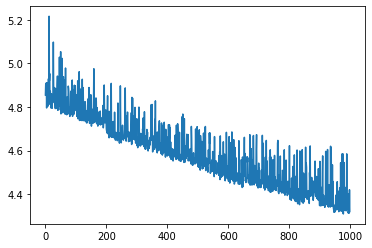

In [59]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

In [19]:
criteria(pred_x0_gray, src_image)

tensor(0.1969, device='cuda:0', grad_fn=<MseLossBackward0>)

In [17]:
cond_for_pixel_path = "/root/stable/stable-diffusion/outputs/imagic/pixel_cond_horse.pt"

print("saving optimized_cond to path:", cond_for_pixel_path)
torch.save(new_cond, cond_for_pixel_path)
print("Done\n")

saving optimized_cond to path: /root/stable/stable-diffusion/outputs/imagic/pixel_cond_horse.pt
Done



In [41]:
'''more stage 2 '''
vgg(pred_x0_gray, src_image)

tensor(2.8935, device='cuda:0', grad_fn=<AddBackward0>)

In [31]:
2. * criteria(pred_x0_gray, src_image)

tensor(0.4580, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

for name, para in model.named_parameters():
    print(name, para.requires_grad)

In [ ]:
cond_path = "/home/xiaopeng/stable-diffusion/outputs/11_19_500_cond.pt"
unet_path = "/home/xiaopeng/stable-diffusion/outputs/11_19_600_unet.pt"

print("saving optimized_cond to path:", cond_path)
torch.save(cond, cond_path)
print("Done\n")

print("saving finetuned unet-model to path:", unet_path)
torch.save(model.model.state_dict(), unet_path)
print("Done\n")

In [ ]:
from collections import OrderedDict

import torch
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

default_model = nn.Sequential(OrderedDict([
    ('base', nn.Linear(4, 2)),
    ('fc', nn.Linear(2, 1))
]))

manual_seed(666)

In [ ]:
psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')
preds = torch.rand([4, 3, 16, 16])
target = torch.rand([4, 3, 16, 16])
state = default_evaluator.run([[preds, target]])
print(state.metrics['psnr'])

In [ ]:
metric = SSIM(data_range=1.0)
metric.attach(default_evaluator, 'ssim')
preds = torch.rand([4, 3, 16, 16])
target = torch.rand([4, 3, 16, 16])
state = default_evaluator.run([[preds, target]])
print(state.metrics['ssim'])